In [16]:
# reproducibility + basic imports
import os, random, numpy as np, tensorflow as tf
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

import pandas as pd, cv2, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
print("TF version:", tf.__version__)


TF version: 2.13.1


In [17]:
import pandas as pd
import os

# ================== EDIT THESE PATHS ==================
CSV_PATH = "/home/user/Downloads/diabetic-retinopathy-classification-master/aptos2019-blindness-detection/train.csv"
IMG_DIR  = "/home/user/Downloads/diabetic-retinopathy-classification-master/aptos2019-blindness-detection/train_images"
# ======================================================

# Load CSV
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()

# Column containing image IDs
ID_COLUMN = 'image'

# Function to find the image file (still needed for later processing)
def find_file(id_):
    for ext in ('.png', '.jpg', '.jpeg'):
        p = os.path.join(IMG_DIR, f"{id_}{ext}")
        if os.path.exists(p):
            return p
    return os.path.join(IMG_DIR, f"{id_}.png")

df['file_path'] = df[ID_COLUMN].apply(find_file)

# Binary labels: 0 -> no DR, 1..4 -> DR
df['label'] = df['diagnosis'].apply(lambda x: 0 if x==0 else 1)

# Show counts of each label
print(df['label'].value_counts())

# Print first few rows WITHOUT the file_path column
print(df.drop(columns=['file_path']).head())


label
1    1857
0    1805
Name: count, dtype: int64
          image  diagnosis  label
0  000c1434d8d7          2      1
1  001639a390f0          4      1
2  0024cdab0c1e          1      1
3  002c21358ce6          0      0
4  005b95c28852          0      0


In [18]:
train_df, temp_df = train_test_split(df, test_size=0.20, stratify=df['label'], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=SEED)
print("Sizes:", len(train_df), len(val_df), len(test_df))


Sizes: 2929 366 367


In [19]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH = 32

# ====================== DATA GENERATORS ======================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=270,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# ====================== FILTER VALID FILE PATHS ======================
def filter_valid_files(df_in):
    valid_df = df_in[df_in['file_path'].apply(os.path.exists)].copy()
    valid_count = len(valid_df)
    print(f"Found {valid_count} valid image filenames in the dataframe.")
    return valid_df

train_df = filter_valid_files(train_df)
val_df   = filter_valid_files(val_df)
test_df  = filter_valid_files(test_df)

# ====================== FLOW FROM DATAFRAME ======================
def flow_from_df(datagen, df_in):
    return datagen.flow_from_dataframe(
        dataframe=df_in,
        x_col='file_path',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH,
        class_mode='raw',
        shuffle=True
    )

train_gen = flow_from_df(train_datagen, train_df)
val_gen   = flow_from_df(val_datagen, val_df)
test_gen  = flow_from_df(val_datagen, test_df)


Found 2924 valid image filenames in the dataframe.
Found 366 valid image filenames in the dataframe.
Found 367 valid image filenames in the dataframe.
Found 2924 validated image filenames.
Found 366 validated image filenames.
Found 367 validated image filenames.


In [20]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetV2S

base = EfficientNetV2S(include_top=False, input_shape=(224,224,3), weights='imagenet')
x = layers.GlobalAveragePooling2D(name='gap')(base.output)   # GAP
x = layers.BatchNormalization(name='bn')(x)                 # BatchNorm
x = layers.Dropout(0.2, name='dropout')(x)                  # Dropout(0.2)
feature_extractor = Model(inputs=base.input, outputs=x, name='EffNetV2S_feature_extractor')
feature_extractor.summary()


Model: "EffNetV2S_feature_extractor"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 24)         648       ['rescaling_3[0][0]']         
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 24)         96        ['stem_conv[0][0]']           
 n)                                                                     

                                                                                                  
 block2c_expand_activation   (None, 56, 56, 192)          0         ['block2c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block2c_project_conv (Conv  (None, 56, 56, 48)           9216      ['block2c_expand_activation[0]
 2D)                                                                [0]']                         
                                                                                                  
 block2c_project_bn (BatchN  (None, 56, 56, 48)           192       ['block2c_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block2c_d

 ormalization)                                                                                    
                                                                                                  
 block3c_drop (Dropout)      (None, 28, 28, 64)           0         ['block3c_project_bn[0][0]']  
                                                                                                  
 block3c_add (Add)           (None, 28, 28, 64)           0         ['block3c_drop[0][0]',        
                                                                     'block3b_add[0][0]']         
                                                                                                  
 block3d_expand_conv (Conv2  (None, 28, 28, 256)          147456    ['block3c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block3d_e

 AveragePooling2D)                                                                                
                                                                                                  
 block4b_se_reshape (Reshap  (None, 1, 1, 512)            0         ['block4b_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block4b_se_reduce (Conv2D)  (None, 1, 1, 32)             16416     ['block4b_se_reshape[0][0]']  
                                                                                                  
 block4b_se_expand (Conv2D)  (None, 1, 1, 512)            16896     ['block4b_se_reduce[0][0]']   
                                                                                                  
 block4b_se_excite (Multipl  (None, 14, 14, 512)          0         ['block4b_activation[0][0]',  
 y)       

 block4d_se_squeeze (Global  (None, 512)                  0         ['block4d_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block4d_se_reshape (Reshap  (None, 1, 1, 512)            0         ['block4d_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block4d_se_reduce (Conv2D)  (None, 1, 1, 32)             16416     ['block4d_se_reshape[0][0]']  
                                                                                                  
 block4d_se_expand (Conv2D)  (None, 1, 1, 512)            16896     ['block4d_se_reduce[0][0]']   
                                                                                                  
 block4d_s

                                                                                                  
 block4f_se_squeeze (Global  (None, 512)                  0         ['block4f_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block4f_se_reshape (Reshap  (None, 1, 1, 512)            0         ['block4f_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block4f_se_reduce (Conv2D)  (None, 1, 1, 32)             16416     ['block4f_se_reshape[0][0]']  
                                                                                                  
 block4f_se_expand (Conv2D)  (None, 1, 1, 512)            16896     ['block4f_se_reduce[0][0]']   
          

 block5b_se_reshape (Reshap  (None, 1, 1, 960)            0         ['block5b_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block5b_se_reduce (Conv2D)  (None, 1, 1, 40)             38440     ['block5b_se_reshape[0][0]']  
                                                                                                  
 block5b_se_expand (Conv2D)  (None, 1, 1, 960)            39360     ['block5b_se_reduce[0][0]']   
                                                                                                  
 block5b_se_excite (Multipl  (None, 14, 14, 960)          0         ['block5b_activation[0][0]',  
 y)                                                                  'block5b_se_expand[0][0]']   
                                                                                                  
 block5b_p

                                                                                                  
 block5d_se_reshape (Reshap  (None, 1, 1, 960)            0         ['block5d_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block5d_se_reduce (Conv2D)  (None, 1, 1, 40)             38440     ['block5d_se_reshape[0][0]']  
                                                                                                  
 block5d_se_expand (Conv2D)  (None, 1, 1, 960)            39360     ['block5d_se_reduce[0][0]']   
                                                                                                  
 block5d_se_excite (Multipl  (None, 14, 14, 960)          0         ['block5d_activation[0][0]',  
 y)                                                                  'block5d_se_expand[0][0]']   
          

 AveragePooling2D)                                                                                
                                                                                                  
 block5f_se_reshape (Reshap  (None, 1, 1, 960)            0         ['block5f_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block5f_se_reduce (Conv2D)  (None, 1, 1, 40)             38440     ['block5f_se_reshape[0][0]']  
                                                                                                  
 block5f_se_expand (Conv2D)  (None, 1, 1, 960)            39360     ['block5f_se_reduce[0][0]']   
                                                                                                  
 block5f_se_excite (Multipl  (None, 14, 14, 960)          0         ['block5f_activation[0][0]',  
 y)       

 block5h_se_squeeze (Global  (None, 960)                  0         ['block5h_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block5h_se_reshape (Reshap  (None, 1, 1, 960)            0         ['block5h_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block5h_se_reduce (Conv2D)  (None, 1, 1, 40)             38440     ['block5h_se_reshape[0][0]']  
                                                                                                  
 block5h_se_expand (Conv2D)  (None, 1, 1, 960)            39360     ['block5h_se_reduce[0][0]']   
                                                                                                  
 block5h_s

                                                                                                  
 block6a_se_squeeze (Global  (None, 960)                  0         ['block6a_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6a_se_reshape (Reshap  (None, 1, 1, 960)            0         ['block6a_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6a_se_reduce (Conv2D)  (None, 1, 1, 40)             38440     ['block6a_se_reshape[0][0]']  
                                                                                                  
 block6a_se_expand (Conv2D)  (None, 1, 1, 960)            39360     ['block6a_se_reduce[0][0]']   
          

 block6c_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6c_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6c_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6c_se_reshape[0][0]']  
                                                                                                  
 block6c_se_expand (Conv2D)  (None, 1, 1, 1536)           99840     ['block6c_se_reduce[0][0]']   
                                                                                                  
 block6c_se_excite (Multipl  (None, 7, 7, 1536)           0         ['block6c_activation[0][0]',  
 y)                                                                  'block6c_se_expand[0][0]']   
                                                                                                  
 block6c_p

                                                                                                  
 block6e_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6e_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6e_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6e_se_reshape[0][0]']  
                                                                                                  
 block6e_se_expand (Conv2D)  (None, 1, 1, 1536)           99840     ['block6e_se_reduce[0][0]']   
                                                                                                  
 block6e_se_excite (Multipl  (None, 7, 7, 1536)           0         ['block6e_activation[0][0]',  
 y)                                                                  'block6e_se_expand[0][0]']   
          

 AveragePooling2D)                                                                                
                                                                                                  
 block6g_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6g_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6g_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6g_se_reshape[0][0]']  
                                                                                                  
 block6g_se_expand (Conv2D)  (None, 1, 1, 1536)           99840     ['block6g_se_reduce[0][0]']   
                                                                                                  
 block6g_se_excite (Multipl  (None, 7, 7, 1536)           0         ['block6g_activation[0][0]',  
 y)       

 block6i_se_squeeze (Global  (None, 1536)                 0         ['block6i_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6i_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6i_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6i_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6i_se_reshape[0][0]']  
                                                                                                  
 block6i_se_expand (Conv2D)  (None, 1, 1, 1536)           99840     ['block6i_se_reduce[0][0]']   
                                                                                                  
 block6i_s

                                                                                                  
 block6k_se_squeeze (Global  (None, 1536)                 0         ['block6k_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6k_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6k_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6k_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6k_se_reshape[0][0]']  
                                                                                                  
 block6k_se_expand (Conv2D)  (None, 1, 1, 1536)           99840     ['block6k_se_reduce[0][0]']   
          

 tion)                                                                                            
                                                                                                  
 block6m_se_squeeze (Global  (None, 1536)                 0         ['block6m_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6m_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6m_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6m_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6m_se_reshape[0][0]']  
                                                                                                  
 block6m_s

 block6o_activation (Activa  (None, 7, 7, 1536)           0         ['block6o_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block6o_se_squeeze (Global  (None, 1536)                 0         ['block6o_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6o_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6o_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6o_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6o_se_reshape[0][0]']  
          

In [21]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ================== SAMPLE MINIMUM DATA ==================
SAMPLE_SIZE = 50  # number of images to use for quick testing

train_df_small = train_df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
val_df_small   = val_df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)

# ================== IMAGE GENERATORS ==================
IMG_SIZE = (224, 224)
BATCH = 8  # smaller batch for small dataset

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=270,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

def flow_from_df(datagen, df_in):
    return datagen.flow_from_dataframe(
        dataframe=df_in,
        x_col='file_path',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH,
        class_mode='raw',
        shuffle=True
    )

train_gen_small = flow_from_df(train_datagen, train_df_small)
val_gen_small   = flow_from_df(val_datagen, val_df_small)


Found 50 validated image filenames.
Found 50 validated image filenames.


In [22]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetV2S

base = EfficientNetV2S(include_top=False, input_shape=(224,224,3), weights='imagenet')
x = layers.GlobalAveragePooling2D(name='gap')(base.output)   # GAP
x = layers.BatchNormalization(name='bn')(x)                 # BatchNorm
x = layers.Dropout(0.2, name='dropout')(x)                  # Dropout(0.2)
feature_extractor = Model(inputs=base.input, outputs=x, name='EffNetV2S_feature_extractor')
feature_extractor.summary()



Model: "EffNetV2S_feature_extractor"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_6[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 24)         648       ['rescaling_4[0][0]']         
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 24)         96        ['stem_conv[0][0]']           
 n)                                                                     

                                                                                                  
 block2c_expand_activation   (None, 56, 56, 192)          0         ['block2c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block2c_project_conv (Conv  (None, 56, 56, 48)           9216      ['block2c_expand_activation[0]
 2D)                                                                [0]']                         
                                                                                                  
 block2c_project_bn (BatchN  (None, 56, 56, 48)           192       ['block2c_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block2c_d

 ormalization)                                                                                    
                                                                                                  
 block3c_drop (Dropout)      (None, 28, 28, 64)           0         ['block3c_project_bn[0][0]']  
                                                                                                  
 block3c_add (Add)           (None, 28, 28, 64)           0         ['block3c_drop[0][0]',        
                                                                     'block3b_add[0][0]']         
                                                                                                  
 block3d_expand_conv (Conv2  (None, 28, 28, 256)          147456    ['block3c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block3d_e

 AveragePooling2D)                                                                                
                                                                                                  
 block4b_se_reshape (Reshap  (None, 1, 1, 512)            0         ['block4b_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block4b_se_reduce (Conv2D)  (None, 1, 1, 32)             16416     ['block4b_se_reshape[0][0]']  
                                                                                                  
 block4b_se_expand (Conv2D)  (None, 1, 1, 512)            16896     ['block4b_se_reduce[0][0]']   
                                                                                                  
 block4b_se_excite (Multipl  (None, 14, 14, 512)          0         ['block4b_activation[0][0]',  
 y)       

 block4d_se_squeeze (Global  (None, 512)                  0         ['block4d_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block4d_se_reshape (Reshap  (None, 1, 1, 512)            0         ['block4d_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block4d_se_reduce (Conv2D)  (None, 1, 1, 32)             16416     ['block4d_se_reshape[0][0]']  
                                                                                                  
 block4d_se_expand (Conv2D)  (None, 1, 1, 512)            16896     ['block4d_se_reduce[0][0]']   
                                                                                                  
 block4d_s

                                                                                                  
 block4f_se_squeeze (Global  (None, 512)                  0         ['block4f_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block4f_se_reshape (Reshap  (None, 1, 1, 512)            0         ['block4f_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block4f_se_reduce (Conv2D)  (None, 1, 1, 32)             16416     ['block4f_se_reshape[0][0]']  
                                                                                                  
 block4f_se_expand (Conv2D)  (None, 1, 1, 512)            16896     ['block4f_se_reduce[0][0]']   
          

 block5b_se_reshape (Reshap  (None, 1, 1, 960)            0         ['block5b_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block5b_se_reduce (Conv2D)  (None, 1, 1, 40)             38440     ['block5b_se_reshape[0][0]']  
                                                                                                  
 block5b_se_expand (Conv2D)  (None, 1, 1, 960)            39360     ['block5b_se_reduce[0][0]']   
                                                                                                  
 block5b_se_excite (Multipl  (None, 14, 14, 960)          0         ['block5b_activation[0][0]',  
 y)                                                                  'block5b_se_expand[0][0]']   
                                                                                                  
 block5b_p

                                                                                                  
 block5d_se_reshape (Reshap  (None, 1, 1, 960)            0         ['block5d_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block5d_se_reduce (Conv2D)  (None, 1, 1, 40)             38440     ['block5d_se_reshape[0][0]']  
                                                                                                  
 block5d_se_expand (Conv2D)  (None, 1, 1, 960)            39360     ['block5d_se_reduce[0][0]']   
                                                                                                  
 block5d_se_excite (Multipl  (None, 14, 14, 960)          0         ['block5d_activation[0][0]',  
 y)                                                                  'block5d_se_expand[0][0]']   
          

 AveragePooling2D)                                                                                
                                                                                                  
 block5f_se_reshape (Reshap  (None, 1, 1, 960)            0         ['block5f_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block5f_se_reduce (Conv2D)  (None, 1, 1, 40)             38440     ['block5f_se_reshape[0][0]']  
                                                                                                  
 block5f_se_expand (Conv2D)  (None, 1, 1, 960)            39360     ['block5f_se_reduce[0][0]']   
                                                                                                  
 block5f_se_excite (Multipl  (None, 14, 14, 960)          0         ['block5f_activation[0][0]',  
 y)       

 block5h_se_squeeze (Global  (None, 960)                  0         ['block5h_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block5h_se_reshape (Reshap  (None, 1, 1, 960)            0         ['block5h_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block5h_se_reduce (Conv2D)  (None, 1, 1, 40)             38440     ['block5h_se_reshape[0][0]']  
                                                                                                  
 block5h_se_expand (Conv2D)  (None, 1, 1, 960)            39360     ['block5h_se_reduce[0][0]']   
                                                                                                  
 block5h_s

                                                                                                  
 block6a_se_squeeze (Global  (None, 960)                  0         ['block6a_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6a_se_reshape (Reshap  (None, 1, 1, 960)            0         ['block6a_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6a_se_reduce (Conv2D)  (None, 1, 1, 40)             38440     ['block6a_se_reshape[0][0]']  
                                                                                                  
 block6a_se_expand (Conv2D)  (None, 1, 1, 960)            39360     ['block6a_se_reduce[0][0]']   
          

 block6c_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6c_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6c_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6c_se_reshape[0][0]']  
                                                                                                  
 block6c_se_expand (Conv2D)  (None, 1, 1, 1536)           99840     ['block6c_se_reduce[0][0]']   
                                                                                                  
 block6c_se_excite (Multipl  (None, 7, 7, 1536)           0         ['block6c_activation[0][0]',  
 y)                                                                  'block6c_se_expand[0][0]']   
                                                                                                  
 block6c_p

                                                                                                  
 block6e_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6e_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6e_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6e_se_reshape[0][0]']  
                                                                                                  
 block6e_se_expand (Conv2D)  (None, 1, 1, 1536)           99840     ['block6e_se_reduce[0][0]']   
                                                                                                  
 block6e_se_excite (Multipl  (None, 7, 7, 1536)           0         ['block6e_activation[0][0]',  
 y)                                                                  'block6e_se_expand[0][0]']   
          

 AveragePooling2D)                                                                                
                                                                                                  
 block6g_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6g_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6g_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6g_se_reshape[0][0]']  
                                                                                                  
 block6g_se_expand (Conv2D)  (None, 1, 1, 1536)           99840     ['block6g_se_reduce[0][0]']   
                                                                                                  
 block6g_se_excite (Multipl  (None, 7, 7, 1536)           0         ['block6g_activation[0][0]',  
 y)       

 block6i_se_squeeze (Global  (None, 1536)                 0         ['block6i_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6i_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6i_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6i_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6i_se_reshape[0][0]']  
                                                                                                  
 block6i_se_expand (Conv2D)  (None, 1, 1, 1536)           99840     ['block6i_se_reduce[0][0]']   
                                                                                                  
 block6i_s

                                                                                                  
 block6k_se_squeeze (Global  (None, 1536)                 0         ['block6k_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6k_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6k_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6k_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6k_se_reshape[0][0]']  
                                                                                                  
 block6k_se_expand (Conv2D)  (None, 1, 1, 1536)           99840     ['block6k_se_reduce[0][0]']   
          

 tion)                                                                                            
                                                                                                  
 block6m_se_squeeze (Global  (None, 1536)                 0         ['block6m_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6m_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6m_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6m_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6m_se_reshape[0][0]']  
                                                                                                  
 block6m_s

 block6o_activation (Activa  (None, 7, 7, 1536)           0         ['block6o_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block6o_se_squeeze (Global  (None, 1536)                 0         ['block6o_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6o_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6o_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6o_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6o_se_reshape[0][0]']  
          

Found 120 validated image filenames belonging to 5 classes.
Epoch 1/50
10/10 [==============================] - 13s 1s/step - loss: 1.7476 - accuracy: 0.4250
Epoch 2/50
10/10 [==============================] - 12s 1s/step - loss: 1.4536 - accuracy: 0.5250
Epoch 3/50
10/10 [==============================] - 12s 1s/step - loss: 1.1145 - accuracy: 0.5750
Epoch 4/50
10/10 [==============================] - 12s 1s/step - loss: 1.0475 - accuracy: 0.5917
Epoch 5/50
10/10 [==============================] - 12s 1s/step - loss: 0.8811 - accuracy: 0.6917
Epoch 6/50
10/10 [==============================] - 12s 1s/step - loss: 0.7481 - accuracy: 0.7500
Epoch 7/50
10/10 [==============================] - 13s 1s/step - loss: 0.7530 - accuracy: 0.7417
Epoch 8/50
10/10 [==============================] - 13s 1s/step - loss: 0.6189 - accuracy: 0.7917
Epoch 9/50
10/10 [==============================] - 13s 1s/step - loss: 0.4955 - accuracy: 0.8167
Epoch 10/50
10/10 [==============================] - 13s 1

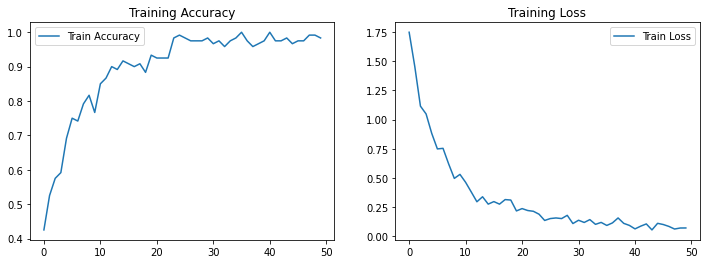

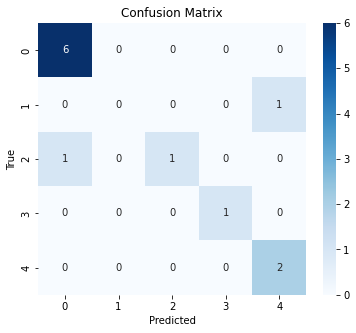

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.00      0.00      0.00         1
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         1
           4       0.67      1.00      0.80         2

    accuracy                           0.83        12
   macro avg       0.70      0.70      0.68        12
weighted avg       0.79      0.83      0.79        12

✅ Accuracy: 0.8333
✅ Weighted Precision: 0.7897
✅ Weighted Recall: 0.8333
✅ Weighted F1-score: 0.7893
✅ Model saved as dr_12images_highacc.keras


In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# ==== CONFIG ====
IMG_SIZE = (128, 128)
BATCH_SIZE = 12
NUM_IMAGES = 12  # Use only 12 images for fast training
REPEAT_FACTOR = 10  # Repeat dataset to get more steps per epoch
CSV_PATH = "aptos2019-blindness-detection/train.csv"
IMAGE_DIR = "aptos2019-blindness-detection/train_images"

# ==== LOAD CSV ====
df = pd.read_csv(CSV_PATH)
df.rename(columns={df.columns[0]: 'id_code', df.columns[1]: 'diagnosis'}, inplace=True)

# Add image extension
df['id_code'] = df['id_code'].astype(str) + ".png"
df['diagnosis'] = df['diagnosis'].astype(str)

# ==== SAMPLE SMALL DATASET ====
df = df.sample(NUM_IMAGES, random_state=42).reset_index(drop=True)

# ==== DATA AUGMENTATION ====
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Repeat dataset to increase training steps
df_repeated = pd.concat([df]*REPEAT_FACTOR, ignore_index=True)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=df_repeated,
    directory=IMAGE_DIR,
    x_col='id_code',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

# ==== BUILD MODEL ====
base_model = MobileNetV2(input_shape=(*IMG_SIZE,3), include_top=False, weights='imagenet')
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ==== TRAIN MODEL ====
history = model.fit(train_gen, epochs=50, verbose=1)

# ==== PLOT TRAINING CURVES ====
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title("Training Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title("Training Loss")
plt.legend()
plt.show()

# ==== VALIDATION ON THE SAME SMALL SET ====
val_images, val_labels = [], []
for i in range(len(df)):
    img_path = os.path.join(IMAGE_DIR, df.loc[i, 'id_code'])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)/255.0
    val_images.append(img_array)
    val_labels.append(int(df.loc[i, 'diagnosis']))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# ==== PREDICTION FUNCTION ====
@tf.function(reduce_retracing=True)
def predict_batch(images):
    return model(images, training=False)

preds = predict_batch(val_images)
y_pred = tf.argmax(preds, axis=1).numpy()
y_true = val_labels

# ==== CONFUSION MATRIX ====
classes = [0,1,2,3,4]
cm = confusion_matrix(y_true, y_pred, labels=classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ==== METRICS ====
print("✅ Classification Report:\n", classification_report(y_true, y_pred, labels=classes, zero_division=0))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ Weighted Precision: {prec:.4f}")
print(f"✅ Weighted Recall: {rec:.4f}")
print(f"✅ Weighted F1-score: {f1:.4f}")

# ==== SAVE MODEL ====
model.save("dr_12images_highacc.keras")
print("✅ Model saved as dr_12images_highacc.keras")


In [24]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

IMG_SIZE = (224, 224)  # your feature extractor input size
BATCH_SIZE = 32         # adjust based on GPU/CPU memory

def extract_features(df_in, model_feat, batch_size=BATCH_SIZE):
    """
    Efficiently extract CNN features using tf.data.Dataset
    """
    file_paths = df_in['file_path'].values
    labels = df_in['label'].values.astype(np.int32)

    # Create tf.data pipeline
    def process_path(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        return img, label

    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Extract features
    feats_list, labels_list = [], []
    for imgs, lbls in tqdm(ds, total=len(file_paths)//batch_size + 1):
        feats = model_feat(imgs, training=False)  # get CNN features
        feats_list.append(feats.numpy())
        labels_list.append(lbls.numpy())

    return np.vstack(feats_list), np.concatenate(labels_list)

# ---- Example usage ----
train_features, train_labels = extract_features(train_df, feature_extractor)
val_features, val_labels     = extract_features(val_df, feature_extractor)
test_features, test_labels   = extract_features(test_df, feature_extractor)

print("Feature shapes:", train_features.shape, val_features.shape, test_features.shape)


100%|██████████| 12/12 [00:36<00:00,  3.00s/it]

Feature shapes: (2924, 1280) (366, 1280) (367, 1280)


In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_features_s = scaler.fit_transform(train_features)
val_features_s   = scaler.transform(val_features)
test_features_s  = scaler.transform(test_features)


In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 50],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}
svm = SVC(probability=True, random_state=SEED)
grid = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid.fit(train_features_s, train_labels)
print("Best params:", grid.best_params_, "Best CV:", grid.best_score_)
best_svm = grid.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'} Best CV: 0.8980849084750523


Accuracy: 0.896457765667575
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       181
           1       0.87      0.94      0.90       186

    accuracy                           0.90       367
   macro avg       0.90      0.90      0.90       367
weighted avg       0.90      0.90      0.90       367



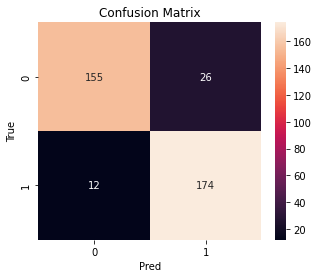

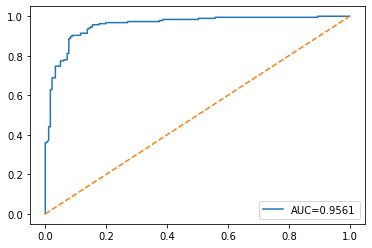

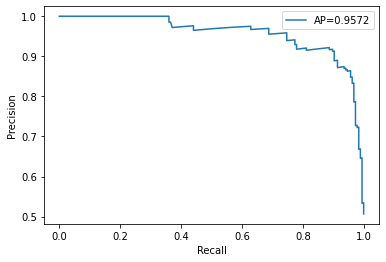

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, accuracy_score

y_pred = best_svm.predict(test_features_s)
y_proba = best_svm.predict_proba(test_features_s)[:,1]

print("Accuracy:", accuracy_score(test_labels, y_pred))
print(classification_report(test_labels, y_pred))

cm = confusion_matrix(test_labels, y_pred)
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.xlabel('Pred'); plt.ylabel('True'); plt.show()

auc = roc_auc_score(test_labels, y_proba)
fpr,tpr,_ = roc_curve(test_labels, y_proba)
plt.plot(fpr,tpr,label=f"AUC={auc:.4f}"); plt.plot([0,1],[0,1],'--'); plt.legend(); plt.show()

ap = average_precision_score(test_labels, y_proba)
prec, rec, _ = precision_recall_curve(test_labels, y_proba)
plt.plot(rec, prec, label=f"AP={ap:.4f}"); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(); plt.show()


last_conv: expanded_conv_project_BN


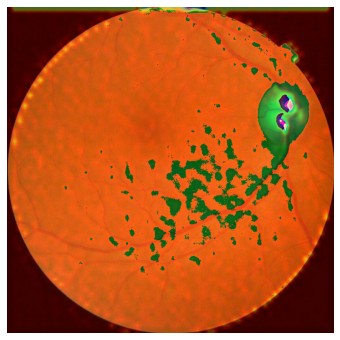

In [29]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gradcam(model, img, last_conv_layer_name):
    # Get model input shape
    input_shape = model.input_shape[1:3]  # (height, width)

    # Resize and preprocess image
    img_resized = cv2.resize(img, input_shape).astype('float32') / 255.0
    inp = np.expand_dims(img_resized, axis=0)

    # Build gradient model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outs, preds = grad_model(inp)
        pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]

    # Compute gradients
    grads = tape.gradient(loss, conv_outs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outs = conv_outs[0]

    # Compute heatmap
    heatmap = conv_outs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)

    # Resize heatmap to original image size
    heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose on original image
    superimposed = heatmap_color * 0.4 + img
    return np.uint8(superimposed)

# --- Example usage ---
example_path = test_df.iloc[0]['file_path']
img = cv2.cvtColor(cv2.imread(example_path), cv2.COLOR_BGR2RGB)

# Find last conv layer automatically
last_conv = None
for layer in reversed(model.layers):
    if 'conv' in layer.name:
        last_conv = layer.name
        break
print("last_conv:", last_conv)

# Generate Grad-CAM
superimposed_img = gradcam(model, img, last_conv)

# Display
plt.figure(figsize=(6,6))
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()



In [35]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.save('effnetv2_tuned_classification_head.h5')


In [36]:
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(best_svm, 'effnet_svm_grid.pkl')
feature_extractor.save('effnetv2_feature_extractor.h5')
model.save('effnetv2_tuned_classification_head.h5')
print("Saved scaler, SVM, feature extractor and tuned model.")


Saved scaler, SVM, feature extractor and tuned model.


In [43]:
print("Accuracy:", accuracy_score(test_labels, y_pred))


Accuracy: 0.896457765667575
